---
title: "When Point Forecasts Are Completely Useless"
author: "Sarem"
date: "2023-01-01"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "While point forecasts are very popular, be aware of some unlucky pitfalls."
---

## Introduction

[In the last article](https://www.sarem-seitz.com/why-i-prefer-probabilistic-forecasts-hitting-time-probabilities/), we discussed one advantage of probabilistic forecasts over point forecasts - namely, handling time-to-exceedance problems. In this post, we will examine another limitation of point forecasts: Higher order statistical properties.

The ideas will be very familiar to those with a background in mathematics or statistics. Readers without formal training in either will therefore probably benefit the most from this article.

By the end of this post, you'll have a better idea of how higher order statistical properties can impact the performance of your forecasts. In particular, we will see how point forecasts can actually completely fail without further adjustment.

## Two examples of point forecast failure
To sensitize you for the issues of point forecasts, let us continue with two very simple examples. Both time-series admit to a pretty simple, auto-regressive data generating process.

We will generate enough data for an auto-regressive Gradient Boosting model to be sensible. Thus, we avoid both using a model that is too inflexible and overfitting due to a lack of data.

### Example 1 - Auto-regressive variance (GARCH)

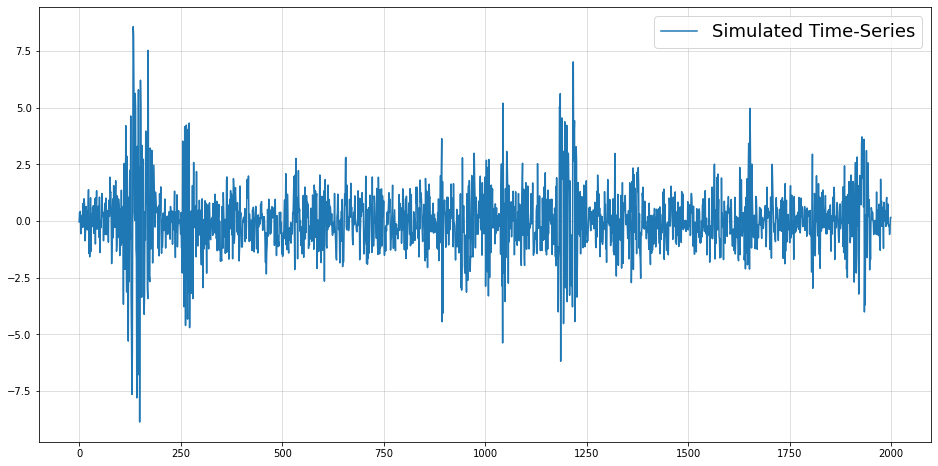

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(987)

time_series = [np.random.normal()*0.1, np.random.normal()*0.1]
sigs = [0.1, 0.1]

for t in range(2000):
    sig_t = np.sqrt(0.1 + 0.24*time_series[-1]**2 + 0.24*time_series[-2]**2 + 0.24*sigs[-1]**2 + 0.24*sigs[-2]**2)
    y_t = np.random.normal() * sig_t
    time_series.append(y_t)
    sigs.append(sig_t)
    
y = np.array(time_series[2:])

plt.figure(figsize = (16,8))
plt.plot(y, label = "Simulated Time-Series")

plt.grid(alpha = 0.5)
plt.legend(fontsize = 18);

This is a standard [GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com) time-series as they are frequently encountered in econometrics. If you want to get some ideas on how you can handle such data, I have also written a few articles:

- [Random Forests and Boosting for ARCH-like volatility forecasts](https://www.sarem-seitz.com/random-forests-and-boosting-for-arch-like-volatility-forecasts/)
- [Multivariate GARCH with Python and Tensorflow](https://www.sarem-seitz.com/multivariate-garch-with-python-and-tensorflow/)
- [Let's make GARCH more flexible with Normalizing Flows](https://www.sarem-seitz.com/lets-make-garch-more-flexible-with-normalizing-flows/)

Anyway, let us use the cookie cutter approach of Machine Learning for time-series for now.  Namely, we use [Nixtla's mlforecast package](https://github.com/Nixtla/mlforecast?ref=sarem-seitz.com) to build an auto-regressive Boosting model for us. (This is not meant to bash on the Nixtla package. In fact, it is really helpful and convenient if you know what you are doing.)

The results look as follows:

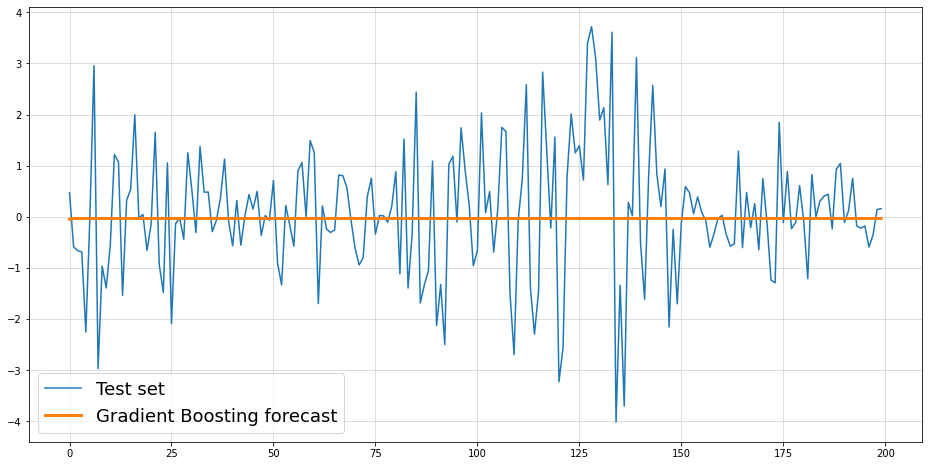

In [3]:
from mlforecast.utils import generate_daily_series
from sklearn.ensemble import GradientBoostingRegressor
from mlforecast import MLForecast

np.random.seed(987)

y_train = y[:1800]
y_test = y[1800:]

series = generate_daily_series(
    n_series=1,
    max_length=10000,
).iloc[:1800,:]

series["y"] = y_train

models = [
    GradientBoostingRegressor(),
]

fcst = MLForecast(
    models=models,
    freq='D',
    lags=[1, 2]
)

fcst.fit(series, id_col='index', time_col='ds', target_col='y')
predictions = fcst.predict(200)


plt.figure(figsize = (16,8))

plt.plot(y_test, label = "Test set")
plt.plot(predictions.iloc[:,1].values, label = "Gradient Boosting forecast", lw=3)

plt.grid(alpha = 0.5)
plt.legend(fontsize = 18);

Unfortunately, the result does not help at all. Although we have provided the actual ground-truth number of lags, the forecast is practically useless.

### Example 2 - Auto-regressive, non-Gaussian data
This next example follows a more cooked up data generating process. Nevertheless, this doesn't preclude some real-world time-series following a similar logic, too:

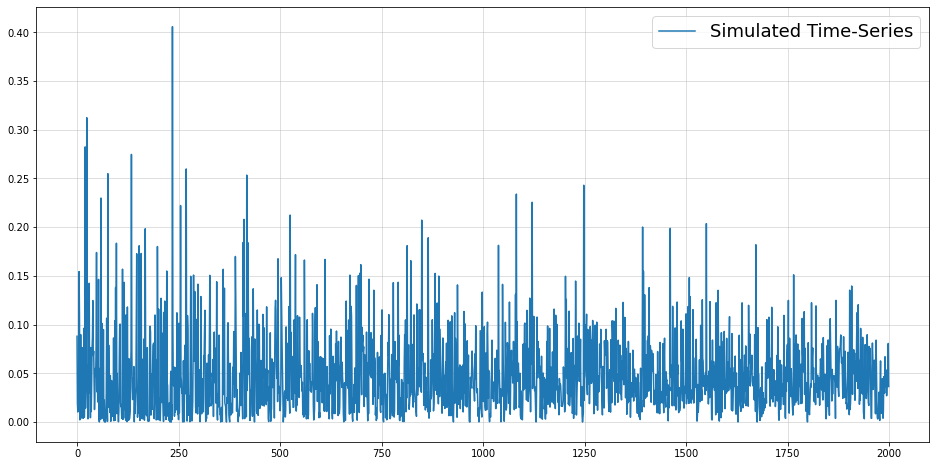

In [5]:
from scipy.stats import beta

np.random.seed(321)

time_series = [beta(0.5,10).rvs()]


for t in range(2000):
    alpha_t = 0.5 + time_series[-1] * 0.025 * t
    beta_t = alpha_t * 20
    y_t = beta(alpha_t, beta_t).rvs()
    time_series.append(y_t)

    
y = np.array(time_series[1:])

plt.figure(figsize = (16,8))
plt.plot(y, label = "Simulated Time-Series")

plt.grid(alpha = 0.5)
plt.legend(fontsize = 18);

Let us check how a Gradient Boosting model performs for this case:

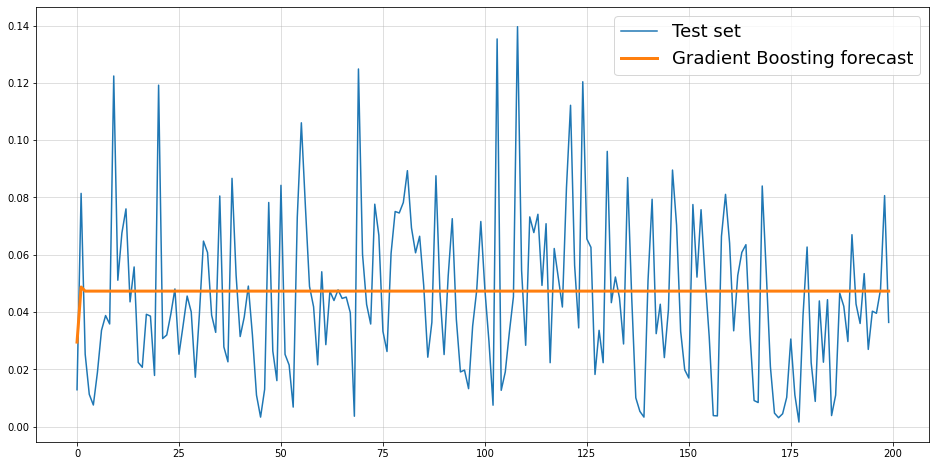

In [6]:
from mlforecast.utils import generate_daily_series
from sklearn.ensemble import GradientBoostingRegressor
from mlforecast import MLForecast

np.random.seed(987)

y_train = y[:1800]
y_test = y[1800:]

series = generate_daily_series(
    n_series=1,
    max_length=10000,
).iloc[:1800,:]

series["y"] = y_train

models = [
    GradientBoostingRegressor(max_depth = 1),
]

fcst = MLForecast(
    models=models,
    freq='D',
    lags=[1]
)

fcst.fit(series, id_col='index', time_col='ds', target_col='y')
predictions = fcst.predict(200)


plt.figure(figsize = (16,8))

plt.plot(y_test, label = "Test set")
plt.plot(predictions.iloc[:,1].values, label = "Gradient Boosting forecast", lw=3)

plt.grid(alpha = 0.5)
plt.legend(fontsize = 18);

Again, the forecast is utterly useless.

## What has gone wrong with our point forecasts?
As you might know, `sklearn.ensemble.GradientBoostingRegressor` minimizes the mean-squared error (MSE) by default. The following is a well known property of MSE-minimization:

> *A distribution's mean minimizes its mean-squared error.*

Mathematically:
$$
\begin{aligned}
& \arg \min _{\hat{f}} \mathbb{E}\left[\left(y_t-\hat{f}\left(y_{t-1}, \ldots, y_{t-s}\right)\right)^2\right] \\
\Rightarrow & \left.\hat{f}\left(y_{t-1}, \ldots, y_{t-s}\right)\right) \equiv \mathbb{E}\left[y_t \mid y_{t-1}, \ldots, y_{t-s}\right]
\end{aligned}
$$
where we presume an arbitrarily large set of admissable functions. Also, we implicitly need to assume that the conditional mean actually exists. This is reasonably likely for most well-behaved forecasting problems.

Thus, both of the above models aim to forecast the mean of the conditional distribution of our observations. The issue here is that the conditional mean is actually constant by construction.

This is obvious for the first example - each observation has a conditional mean of zero. For the second example, we would have to do some math for a formal proof that is left to the interested reader.

Now, although the conditional mean remains constant over time, our time-series is still far from being just pure noise. Predicting the mean via MSE-minimization was rather inadequate to describe the future.

We can go even further and proclaim:

> *Even a perfect (point-) forecasting model can be useless if the forecast quantity is uninformative.*

We can visualize via plots of conditional densities against conditional means from our examples:

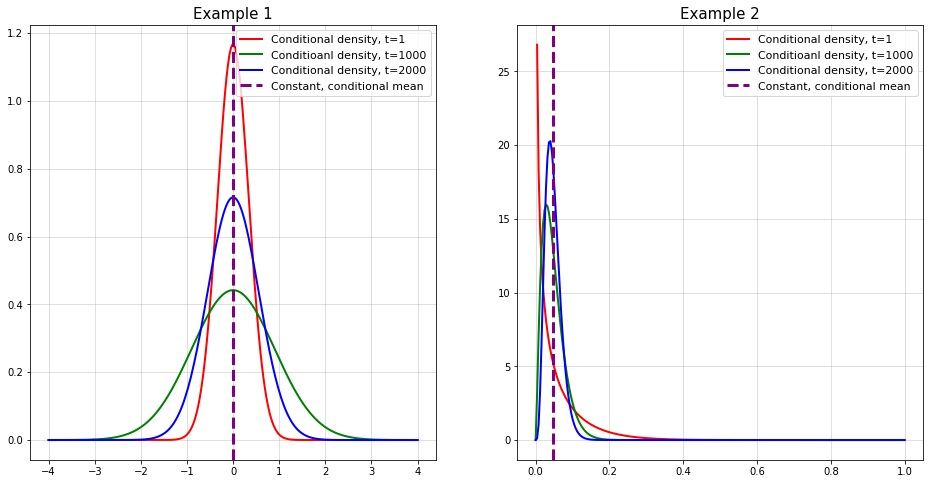

In [10]:
from scipy.stats import norm

np.random.seed(987)
line_1 = np.linspace(-4,4,250)

time_series = [np.random.normal()*0.1, np.random.normal()*0.1]
sigs = [0.1, 0.1]
conditional_pdfs_1 = [norm(0,0.1).pdf(line_1)]*2
conditional_means_1 = [0., 0.]

for t in range(2000):
    sig_t = np.sqrt(0.1 + 0.24*time_series[-1]**2 + 0.24*time_series[-2]**2 + 0.24*sigs[-1]**2 + 0.24*sigs[-2]**2)
    y_t = np.random.normal() * sig_t
    time_series.append(y_t)
    sigs.append(sig_t)
    
    conditional_pdfs_1.append(norm(0,sig_t).pdf(line_1))
    conditional_means_1.append(0.)
    
conditional_pdfs_1 = conditional_pdfs_1[2:]
conditional_means_1 = conditional_means_1[2:]


np.random.seed(987)

line_2 = np.linspace(0,1,250)

time_series = [beta(0.5,10).rvs()]
conditional_pdfs_2 = [beta(0.5,10).pdf(line_2)]
conditional_means_2 = [beta(0.5,10).mean()]


for t in range(2000):
    alpha_t = 0.5 + time_series[-1] * 0.025 * t
    beta_t = alpha_t * 20
    y_t = beta(alpha_t, beta_t).rvs()
    time_series.append(y_t)
    
    conditional_pdfs_2.append(beta(alpha_t, beta_t).pdf(line_2))
    conditional_means_2.append(beta(alpha_t, beta_t).mean())

    
conditional_pdfs_2 = conditional_pdfs_2[1:]
conditional_means_2 = conditional_means_2[1:]


_, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

ax1.plot(line_1, conditional_pdfs_1[0], label = "Conditional density, t=1", lw=2, c="red")
ax1.plot(line_1, conditional_pdfs_1[999], label = "Conditioanl density, t=1000", lw=2, c="green")
ax1.plot(line_1, conditional_pdfs_1[1999], label = "Conditional density, t=2000", lw=2, c="blue")

ax1.axvline([conditional_means_1[0]], lw=3, c="purple", ls="dashed", label = "Constant, conditional mean")
ax1.grid(alpha = 0.5)

ax1.legend(fontsize=11)
ax1.set_title("Example 1", fontsize = 15)


ax2.plot(line_2, conditional_pdfs_2[0], label = "Conditional density, t=1", lw=2, c="red")
ax2.plot(line_2, conditional_pdfs_2[999], label = "Conditioanl density, t=1000", lw=2, c="green")
ax2.plot(line_2, conditional_pdfs_2[1999], label = "Conditional density, t=2000", lw=2, c="blue")

ax2.axvline([conditional_means_2[0]], lw=3, c="purple", ls="dashed", label = "Constant, conditional mean")
ax2.grid(alpha = 0.5)

ax2.legend(fontsize = 11)
ax2.set_title("Example 2", fontsize = 15);

On the one hand, the conditional distribution is varying and can be predicted from past by construction. The conditional mean, however, is constant and does not tell us anything about the future distribution.

## What can we do?
At first glance, the above issues paint a rather grim picture of the capabilities of raw point forecasts. As always, the situation is of course much more granular.

Therefore, let us discuss a rough pathway of what to do if your point forecasts aren't really cutting it.

### Assess if you even have a problem at all - point forecasts can still work
As we have just seen, point forecasts can fail miserably. Given that they are being widely used, however, indicates that they will cause trouble for your problem. Many forecasting problems can be solved reasonably well with standard approaches.

Sometimes, you just need to put in a little more effort into your model. Simply using another loss function or another non-linear transformation of your features might be sufficient. Once you observe that a point forecast simply won't cut it though, it might be time to go probabilistic.

Two cases can be good indicators:

#### 1) Your point forecasts show little variation and are almost constant.
Mathematically:
$$
\hat{y}_t \mid y_{t-1}, \ldots y_{t-s} \approx C
$$
This is what happened in our examples and should be visible in your model validation steps. As we have seen, there is no reason to conclude that something is wrong with your model or your data yet.

#### 2) Occasional, large outliers frequently make your point forecasts useless.
This issue leads us into the domain of extreme-value theory and probably deserves a blog series of its own. Hence, we will only take a brief look at what is happening here.

As an exaggerated, yet illustrative example, consider the following time-series:

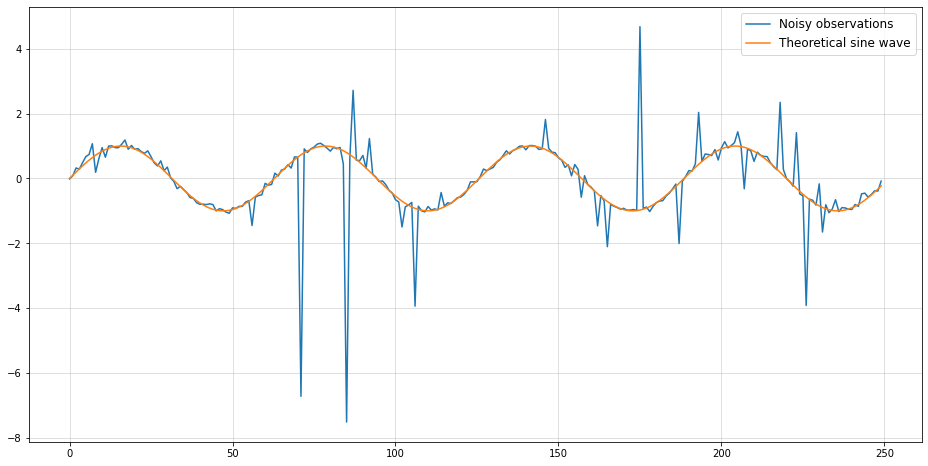

In [11]:
from scipy.stats import cauchy

np.random.seed(987)

plt.figure(figsize = (16,8))

plt.plot(cauchy(np.sin(0.1 * np.arange(250)),0.05).rvs(), label = "Noisy observations")
plt.plot(np.sin(0.1 * np.arange(250)), label = "Theoretical sine wave")
plt.grid(alpha = 0.5)
plt.legend(fontsize=12)

This is nothing more than samples from a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution?ref=sarem-seitz.com) whose location is determined by a sine. Now, let us see how the MSE evolves with increasing sample size if our (point-) forecast was just a continuance of the underlying sine:

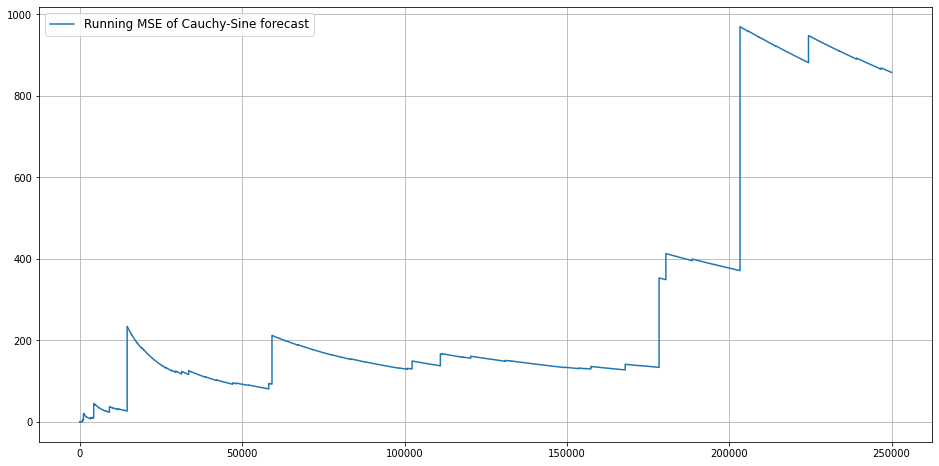

In [12]:
np.random.seed(987)

T = 250000

large_sample = cauchy(np.sin(0.1 * np.arange(T)),0.05).rvs()
optimal_point_forecast = np.sin(0.1 * np.arange(T))

running_mse = np.cumsum((large_sample - optimal_point_forecast)**2)/np.arange(1,T+1)

plt.figure(figsize = (16,8))
plt.plot(running_mse, label = "Running MSE of Cauchy-Sine forecast")
plt.grid()
plt.legend(fontsize = 12)

Surprisingly, the MSE doesn't even converge after **250.000** (!) observations. No matter how much data you observe, your **average** (!) squared error keeps growing. This is a property of a certain family of probability distributions that the Cauchy is part of.

You will likely never observe such a monstrosity in your day-to-day life. Almost all real-world time-series adhere to certain limitations that make an infinite MSE unlikely.

Nevertheless, it would be helpful to get at least some idea of how likely you will observe large outliers. Imagine, for example, how valuable a rough probability of an extreme collapse of the tourism sector could have been in 2019.

### Adjust your definition of a 'useful' forecast
Of course it can be very difficult to convince your stakeholders of the above issues of point forecasts. For business folks, probabilistic approaches might look like unnecessary rocket science.

Rather, we typically measure forecasting success by how closely predictions match future observations. If something goes wrong, just add more data and hope that you'll be better off next time. However, consider the underlying complexity of most time-series systems. What are your chances of ever collecting all the relevant data?

This is like trying to collect and process all relevant factors to predict the exact outcome of a game of roulette. While possible in theory, the sheer amount of granularity makes this impossible in practice.

Nevertheless, you might discover that there are some physical flaws in the roulette table. If these flaws are skewing the odds in a certain direction, making your bets accordingly could make you a fortune in the long run.

If we transfer this analogy to general forecasting problems, this leads us to a paradigm shift:

> **Instead of trying to predict the future as exactly as possible, forecast models should optimize our odds when betting on future outcomes.
**

Taking this betting metaphor further, we arrive at three conclusions for forecasting:

#### 1) Real-world decisions are almost always made under uncertainty
Consider the following problem:

You are an ice cream vendor and want to optimize your daily inventoy.  For simplicity, we presume that each day, you either

- Sell exactly `10` pounds of ice-cream with a `90%` chance or
- Sell `0` pounds with a `10%` chance (because the weather is really bad, you know)

Also, presume that

- You can buy `1` pound of ice cream for `1` money at the beginning of each day
- Sell `1` pound for `1.2` money
- Your ice-cream inventory goes to zero at the end of each day (no overnight warehousing)
- If your total losses exceed `-10` money you are going bankrupt

Imagine you are building a demand forecast model for that problem to decide how much ice-cream you want to sell. If you go the point-forecast + MSE route, your result would be as follows:

Expected demand is $0.9\cdot 10+0.1\cdot 0 = 9$, therefore the MSE-minimizing forecast is also 9 per day. Are you going to buy `9` pounds of ice-cream each day? What about the risk of bankruptcy if you don't sell anything multiple times in a row?

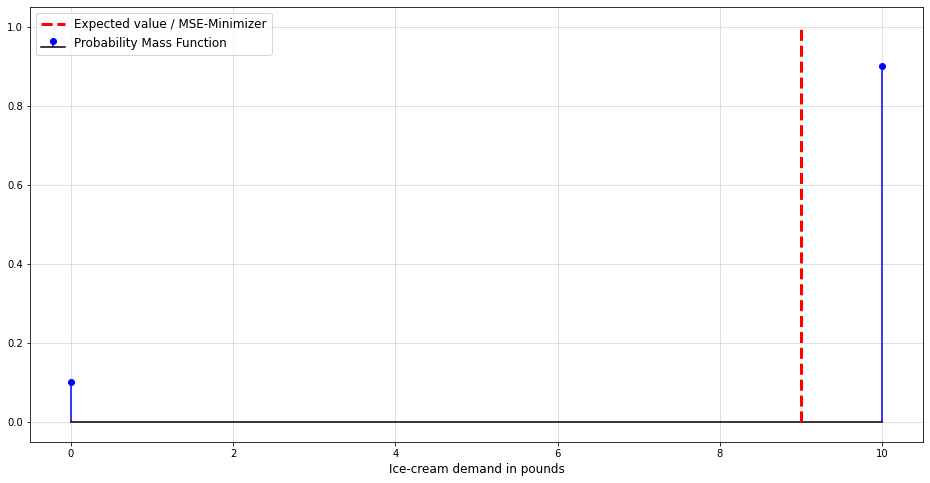

In [13]:
plt.figure(figsize = (16,8))

plt.stem([0.,10.], [0.1,0.9], linefmt='b-', markerfmt='bo', basefmt='black', label = "Probability Mass Function")
plt.plot([9,9],[0,1], c="red", lw=3, ls="dashed", label = "Expected value / MSE-Minimizer")
plt.xlabel("Ice-cream demand in pounds", fontsize=12)
plt.grid(alpha = 0.5)
plt.legend(fontsize = 12);

This is the point where uncertainty comes into play and you need to decide on how much risk you want to take. As often in life, this is another trade-off between profit and risk.

Unfortunately, the point-forecast alone doesn't account for any uncertainty.

Let us now presume that we had a probabilistic forecast model that was able to predict the respective probability mass function (pmf). From here, we can derive our earnings $R$ for day $t$ as a random variable given our inventory $x$:
$$
\begin{gathered}
R\left(x_t\right)= \begin{cases}\min \left(x_t, 10\right) \cdot 1.2-x_t & \text { if } S_t=1 \\
-x_t & \text { if } S_t=0\end{cases} \\
S_t \stackrel{i . i . d}{\sim} \mathcal{B e r}(0.9)
\end{gathered}
$$
This information could then be used in a [stochastic program](https://en.wikipedia.org/wiki/Stochastic_programming?ref=sarem-seitz.com#:~:text=A%20stochastic%20program%20is%20an,assumed%20to%20be%20known%20exactly.). The latter can be seen as a probabilistic extension to deterministic optimization. Here, we can also account for and optimize our risk when dealing with real-world uncertainty.

In fact, real-world complexity is worlds beyond our little ice-cream example. Consider yourself what this means for the likelihood that reality will diverge from your point forecasts.

#### 2) Many small bets are safer than a few large ones
Back to the flawed roulette table, imagine that the probability of 0 is slightly higher than expected. Would you place all your chips on 0 in a single run or place small amounts on it for many rounds?

If you are unlucky, even the smallest possible bet size could lead you into bankruptcy. The chances of this happening are, nevertheless, much larger if you go all-in in a single turn. While it is beyond this article to discuss proper bet sizing, the [Kelly criterion](https://en.wikipedia.org/wiki/Kelly_criterion?ref=sarem-seitz.com) might be a useful start.  

In practice, this could mean going from monthly forecasts to daily forecasts. That is of course a very simplistic recommendation. Subject to other factors, daily forecasts might still be less accurate or not useful at all. At this point, yours and your stakeholder's expertise are necessary to find the right balance.

#### 3) Sometimes, it's better not to play the game at all
Let's face it, there are always situations where you can only lose in the long run. If the signal-to noise ratio of your time-series is too low, it can be impossible to provide useful predictions.

Hedge funds with very deep pockets are [paying absurd sums of money for alternative data](https://edition.cnn.com/2019/07/10/investing/hedge-fund-drones-alternative-data/index.html?ref=sarem-seitz.com). All that just to make their forecasts a tiny bit more accurate than that of their competitors. Unless you have access to the same data (if it is even good at all), you are unlikely to consistently outperform them on the same bets.

In case you have reached this point, you might want to look for new data to improve your forecasts. If that doesn't help either, it could even make sense to rely on respective forecasts altogether.

### Create multiple point forecasts of relevant summary statistics
Instead of focusing on forecasting mean via MSE-minimzation (or median through MAE-minimization),
$$
\mathbb{E}\left[Y_t \mid y_{t-1}, \ldots, y_{t-s}\right]
$$
you could predict other quantities that describe your distribution.

In Example 1, the most obvious would be conditional variance
$$
\operatorname{Var}\left[Y_t \mid y_{t-1}, \ldots, y_{t-s}\right].
$$
You can find a short overview on how to forecast conditional variance in [this article](https://www.sarem-seitz.com/random-forests-and-boosting-for-arch-like-volatility-forecasts/#:~:text=Estimating%20Variance%20directly).

Once your model predicts a period of high variance, you could decide to play it safer. What 'playing it safe' means is obviously depending on the context of your forecasting problem.

Example 2 might also benefit from a conditional variance forecast. However, notice that [conditional skewness](https://en.wikipedia.org/wiki/Skewness?ref=sarem-seitz.com) is also playing a role here. One approach to deal with this situation might be a forecast of conditional quantiles, i.e.
$$
\begin{gathered}
F_{Y_t \mid y_{t-1}, \ldots y_{t-s}}^{-1}(\alpha) \\
\alpha \in(0,1)
\end{gathered}
$$
This is known as [**quantile regression**](https://en.wikipedia.org/wiki/Quantile_regression?ref=sarem-seitz.com) and, e.g., sklearn's GradientBoostingRegressor actually implements the respective loss.

Which quantities you should choose will ultimately depend on your specific problem. The biggest advantage here is that you don't make any assumptions about the underlying distribution. Rather, you just let your model 'learn' the important aspects of the distribution that you care about.

On the other hand, it will be difficult to perform stochastic optimization with this approach. After, all you just compress the most relevant information into a several point forecasts. If you want to calculate the formally best decision given some forecast, you will therefore likely have to

### Replace your point forecast by a probabilistic forecast
The most challenging but also the most holistic approach. As we saw, the success of probabilistic methods often depends on the probability distribution you choose.

Technically, [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics?ref=sarem-seitz.com) and ML methods can learn a probability distribution from the data, too. Keep in mind though, that time-series problems often involve much fewer observations than your typical ML use-case. As a result, these approaches can easily fall prey to overfitting here.

Especially if you are a Python user, you will probably have to implement many models yourself. Contrary to R, the Python ecosystem around forecasting seems to be much more focused on point forecasts. In case you only need a SARIMAX-like solution, `statsmodels` will, however, be your friend.

Below, I also summarized the three different approaches to forecasting that we have discussed so far. Keep in mind that there are advantages and disadvantages to all three.

![Different forecasting styles compared.](/images/when-point-forecasts-are-completely-useless/forecasting_compared.png){fig-alt="Different forecasting styles compared."}

## Conclusion
Hopefully, you now have a better idea of the pitfalls of point forecasts. While point forecasts are not bad per se, they just show you an incomplete picture of what is happening in an uncertain world.

On the other hand, probabilistic forecasts offer a much richer perspective on the future of a given time-series. If you need a sound approach to handle the uncertainty of real-world complex systems, this is the way to go.  Keep in mind, though, that this route will require more manual effort in many situations.

## References
**[1]** Hamilton, James Douglas. Time series analysis. Princeton university press, 2020.

**[2]** Hyndman, Rob J., & Athanasopoulos, George. Forecasting: principles and practice. OTexts, 2018.